In [1]:
#============================================================
# DSRN for Double pendulum Chaotic Data Prediction
# Predict next timepoint from previous timepoint
#============================================================

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import time
import os

# =====================================================
# LOAD chaotic data
# =====================================================
file = "double_pendulum_chaotic_data.csv"
df = pd.read_csv(file)
expr = df.values       # shape (3*T, num_samples)

num_samples = expr.shape[1]
T = 7
num_genes = 4  # θ1, θ2, ω1, ω2

print("Loaded data:", expr.shape)
print("Variables:", num_genes, "Timepoints:", T, "Samples:", num_samples)

# =====================================================
# FORM INPUT → OUTPUT PAIRS FOR EACH VARIABLE
# X: t → t+1
# Y: next timepoint
# =====================================================
X = []
Y = []

for g in range(num_genes):
    block = expr[g*T:(g+1)*T, :]   # rows for this variable (T x num_samples)
    for t in range(T-1):
        X.append(block[t, :])
        Y.append(block[t+1, :])

X = np.array(X)   # shape ((T-1)*num_genes, num_samples)
Y = np.array(Y)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

# =====================================================
# NORMALIZE
# =====================================================
scaler_in = StandardScaler()
scaler_out = StandardScaler()

X_norm = scaler_in.fit_transform(X.T).T       # (input_dim, samples)
Y_norm = scaler_out.fit_transform(Y.T).T      # (output_dim, samples)

M = X_norm.shape[0]   # input dimension
P = Y_norm.shape[0]   # output dimension
D = X_norm.shape[1]   # number of samples

print("Input dim:", M, "Output dim:", P, "Samples:", D)


Matplotlib is building the font cache; this may take a moment.


Loaded data: (28, 2000)
Variables: 4 Timepoints: 7 Samples: 2000
X shape: (24, 2000)
Y shape: (24, 2000)
Input dim: 24 Output dim: 24 Samples: 2000


In [2]:
seeds = [42, 46, 2, 10, 60, 80, 150]
N_values = list(range(2, 10, 1)) + list(range(10, 151, 5))

output_file = "DSRN_double_pendulum_all_seeds_1.csv"

# Remove file if it exists (fresh run)
if os.path.exists(output_file):
    os.remove(output_file)


for seed in seeds:
    print(f"\n========== Running seed {seed} ==========")
    np.random.seed(seed)

    # --- Train / test split (seeded) ---
    samples = np.arange(num_samples)
    train_idx, test_idx = train_test_split(
        samples, test_size=0.2, random_state=seed
    )

    # Storage for this seed
    train_corr_list = []
    test_corr_list  = []
    train_mse_list  = []
    test_mse_list   = []
    time_list       = []
    N_list          = []

    for N in N_values:
        start_time = time.time()

        # --- RESERVOIR PARAMETERS ---
        t_initial, t_final = 0, 1
        param_range_reservoir = [(9.9, 10.1), (27.9, 28.1), (2.65, 2.70)]

        reservoir_params = np.array([
            [np.random.uniform(low, high) for low, high in param_range_reservoir] +
            [np.random.uniform(1, 8)]
            for _ in range(N)
        ])

        R = np.random.uniform(-1, 1, size=(3*N, M))

        # --- LORENZ SYSTEM ---
        def lorenz_system(t, X, params):
            X = X.reshape(N, 3)
            dxdt = params[:, 0] * (X[:, 1] - X[:, 0]) / params[:, 3]
            dydt = (X[:, 0] * (params[:, 1] - X[:, 2]) - X[:, 1]) / params[:, 3]
            dzdt = (X[:, 0] * X[:, 1] - params[:, 2] * X[:, 2]) / params[:, 3]
            return np.stack([dxdt, dydt, dzdt], axis=1).ravel()

        # --- RESERVOIR COMPUTATION ---
        phi = np.zeros((3*N, D))
        for i in range(D):
            inp = R @ X_norm[:, i]
            sol = solve_ivp(
                lorenz_system,
                (t_initial, t_final),
                inp,
                t_eval=[t_final],
                args=(reservoir_params,),
                rtol=1e-6,
                atol=1e-9
            )
            phi[:, i] = sol.y[:, -1]

        # --- TRAIN / TEST ---
        phi_train = phi[:, train_idx].T
        phi_test  = phi[:, test_idx].T
        Y_train   = Y_norm[:, train_idx].T
        Y_test    = Y_norm[:, test_idx].T

        # --- READOUT ---
        S_T, *_ = np.linalg.lstsq(phi_train, Y_train, rcond=None)
        S = S_T.T

        # --- PREDICT ---
        pred_train = scaler_out.inverse_transform(
            (S @ phi[:, train_idx]).T
        ).T
        pred_test = scaler_out.inverse_transform(
            (S @ phi[:, test_idx]).T
        ).T

        Y_train_true = Y[:, train_idx]
        Y_test_true  = Y[:, test_idx]

        # --- METRICS ---
        mse_train = np.mean((pred_train - Y_train_true)**2)
        mse_test  = np.mean((pred_test - Y_test_true)**2)
        corr_train = pearsonr(pred_train.ravel(), Y_train_true.ravel())[0]
        corr_test  = pearsonr(pred_test.ravel(), Y_test_true.ravel())[0]

        elapsed_time = time.time() - start_time

        # --- SAVE ---
        N_list.append(N)
        train_corr_list.append(corr_train)
        test_corr_list.append(corr_test)
        train_mse_list.append(mse_train)
        test_mse_list.append(mse_test)
        time_list.append(elapsed_time)

        print(
            f"Seed={seed}, N={N}, Time={elapsed_time:.2f}s, "
            f"Train Corr={corr_train:.3f}, Test Corr={corr_test:.3f}"
        )

    # --- SAVE RESULTS (APPEND TO SINGLE FILE) ---
    results_df = pd.DataFrame({
        "seed": seed,
        "N": N_list,
        "train_corr": train_corr_list,
        "test_corr": test_corr_list,
        "train_mse": train_mse_list,
        "test_mse": test_mse_list,
        "time_sec": time_list
    })
    
    results_df.to_csv(
        output_file,
        mode="a",
        header=not os.path.exists(output_file),
        index=False
    )
    
    print(f"Appended seed {seed} to {output_file}")



========== Running seed 42 ==========
Seed=42, N=2, Time=3.87s, Train Corr=0.444, Test Corr=0.427
Seed=42, N=3, Time=6.51s, Train Corr=0.636, Test Corr=0.637
Seed=42, N=4, Time=7.58s, Train Corr=0.639, Test Corr=0.609
Seed=42, N=5, Time=8.39s, Train Corr=0.675, Test Corr=0.671
Seed=42, N=6, Time=9.35s, Train Corr=0.420, Test Corr=0.415
Seed=42, N=7, Time=9.76s, Train Corr=0.479, Test Corr=0.459
Seed=42, N=8, Time=5.82s, Train Corr=0.770, Test Corr=0.779
Seed=42, N=9, Time=5.83s, Train Corr=0.658, Test Corr=0.604
Seed=42, N=10, Time=9.53s, Train Corr=0.743, Test Corr=0.749
Seed=42, N=15, Time=13.15s, Train Corr=0.862, Test Corr=0.859
Seed=42, N=20, Time=11.92s, Train Corr=0.897, Test Corr=0.895
Seed=42, N=25, Time=11.25s, Train Corr=0.911, Test Corr=0.902
Seed=42, N=30, Time=10.72s, Train Corr=0.942, Test Corr=0.938
Seed=42, N=35, Time=11.27s, Train Corr=0.968, Test Corr=0.966
Seed=42, N=40, Time=12.06s, Train Corr=0.963, Test Corr=0.957
Seed=42, N=45, Time=12.92s, Train Corr=0.971, Te

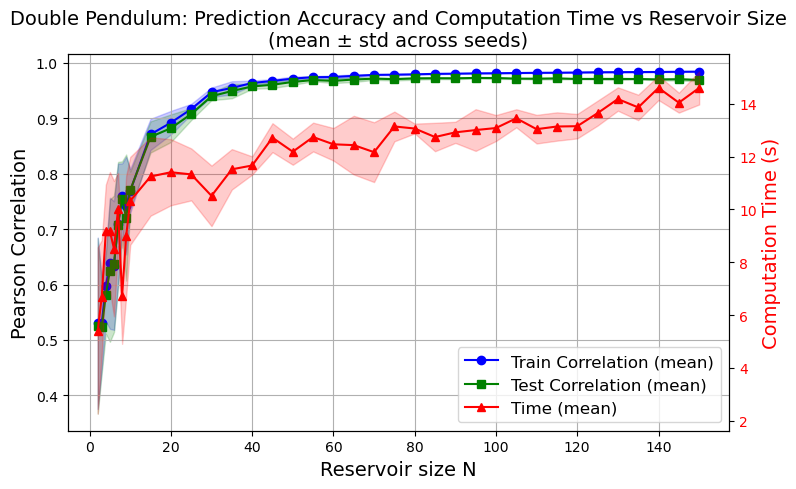

In [3]:
# --- Load combined results ---
df = pd.read_csv("DSRN_double_pendulum_all_seeds_1.csv")

# --- Group by reservoir size ---
grouped = df.groupby("N")

N_list = grouped.mean().index.values

train_corr_mean = grouped["train_corr"].mean().values
train_corr_std  = grouped["train_corr"].std().values

test_corr_mean  = grouped["test_corr"].mean().values
test_corr_std   = grouped["test_corr"].std().values

time_mean = grouped["time_sec"].mean().values
time_std  = grouped["time_sec"].std().values


fig, ax1 = plt.subplots(figsize=(8, 5))

# ===============================
# Left y-axis: Pearson Correlation
# ===============================
ax1.set_xlabel("Reservoir size N", fontsize=14)
ax1.set_ylabel("Pearson Correlation", fontsize=14)

ax1.plot(
    N_list, train_corr_mean,
    color="blue", marker="o", label="Train Correlation (mean)"
)
ax1.fill_between(
    N_list,
    train_corr_mean - train_corr_std,
    train_corr_mean + train_corr_std,
    color="blue", alpha=0.2
)

ax1.plot(
    N_list, test_corr_mean,
    color="green", marker="s", label="Test Correlation (mean)"
)
ax1.fill_between(
    N_list,
    test_corr_mean - test_corr_std,
    test_corr_mean + test_corr_std,
    color="green", alpha=0.2
)

ax1.tick_params(axis="y")
ax1.grid(True)

# ===============================
# Right y-axis: Computation Time
# ===============================
ax2 = ax1.twinx()
ax2.set_ylabel("Computation Time (s)", fontsize=14, color="red")

ax2.plot(
    N_list, time_mean,
    color="red", marker="^", label="Time (mean)"
)
ax2.fill_between(
    N_list,
    time_mean - time_std,
    time_mean + time_std,
    color="red", alpha=0.2
)

ax2.tick_params(axis="y", labelcolor="red")

# ===============================
# Combined legend
# ===============================
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="lower right",
    fontsize=12
)

plt.title(
    "Double Pendulum: Prediction Accuracy and Computation Time vs Reservoir Size\n"
    "(mean ± std across seeds)",
    fontsize=14
)

plt.tight_layout()

# ===============================
# SAVE FIGURE
# ===============================
plt.savefig(
    "double_pendulum_accuracy_time_vs_N_mean_std_2.jpeg",
    format ='jpeg',
    dpi=650,
    bbox_inches="tight"
)

plt.show()
